In [ ]:
pip install tensorflow

## PENYIMPAN DATA GAMBAR

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random


## 1.1 Penyimpan direktori dan Data

In [ ]:
images_path = "/content/drive/MyDrive/DataGigi"
train_path = "/train"
val_path = "/validation"
test_path = "/test"

In [ ]:
subdirectories = [f.name for f in os.scandir(images_path+train_path) if f.is_dir()]

print("Daftar nama subdirektori:")
for subdir in subdirectories:
    print(subdir)

Daftar nama subdirektori:
Bukan Gambar Gigi
Gigi Berlubang
Plak Gigi
Gigi Sehat
Bengkak Gusi


In [ ]:
# fungsi untuk menampilkan contoh gambar secara acak
def view_random_image(data_dir, class_dir, n_row=1, n_col=1):
    target_dir = images_path + "/" + data_dir + "/" + class_dir + "/"

    rand_images = random.sample(os.listdir(target_dir), 4)

    fig, axs = plt.subplots(n_row, n_col)

    for i, ax in enumerate(axs.flat):
        img = mpimg.imread(target_dir + rand_images[i])
        ax.imshow(img)
        ax.set_title(f"{class_dir} {i+1}\n{img.shape}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

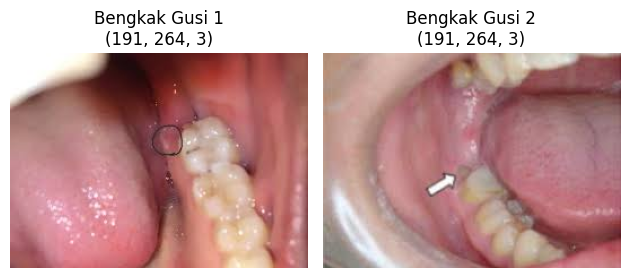

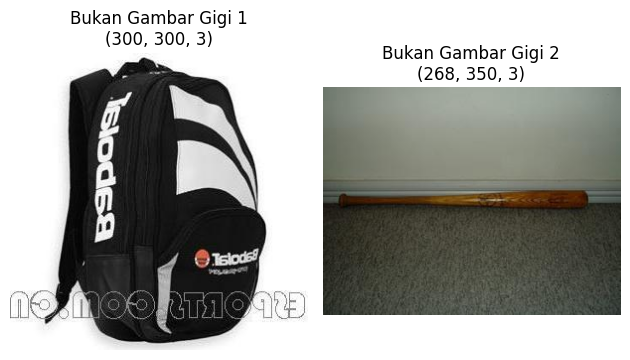

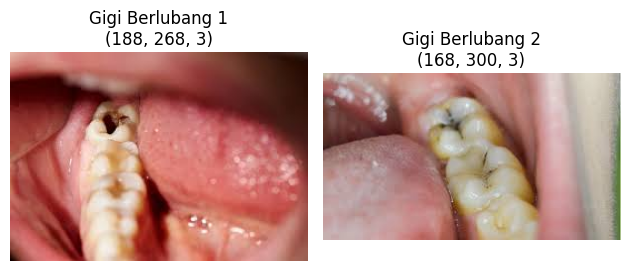

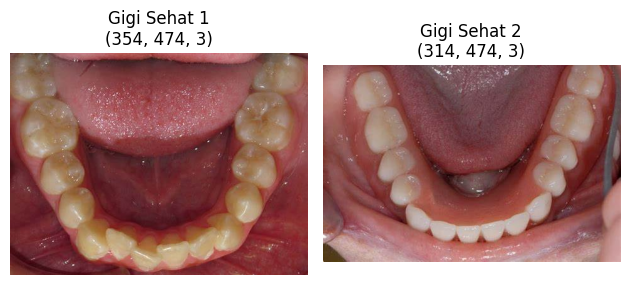

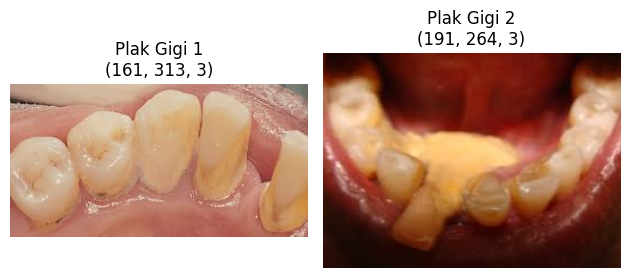

In [ ]:
# contoh menampilkan gambar secara acak
view_random_image("train", "Bengkak Gusi", 1, 2)
view_random_image("train", "Bukan Gambar Gigi", 1, 2)
view_random_image("train", "Gigi Berlubang", 1, 2)
view_random_image("train", "Gigi Sehat", 1, 2)
view_random_image("train", "Plak Gigi", 1, 2)

## 1.2 Image Data Generator

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
tf.random.set_seed(42)

# pengaturan data training dengan scaling images saja
# train_datagen = ImageDataGenerator(rescale=1.0 / 255)

# pengaturan data training dengan berbagai augmentasi
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# pengaturan data validasi selama pelatihan
val_datagen = ImageDataGenerator(rescale=1./255)

# pengaturan data uji untuk evaluasi model
test_datagen = ImageDataGenerator(rescale=1./255)

# menentukan ukuran gambar untuk proses pelatihan
img_size = (224, 224)

# menyiapkan data training dengan pengaturan yang sudah ditentukan
train_data = train_datagen.flow_from_directory(images_path + train_path,
                                               target_size=img_size,
                                               batch_size=32,
                                               class_mode='categorical',
                                               seed=42)

 # menyiapkan data validasi
val_data = val_datagen.flow_from_directory(images_path + val_path,
                                           target_size=img_size,
                                           batch_size=32,
                                           class_mode='categorical',
                                           seed=42)

# menyiapkan data uji
test_data = test_datagen.flow_from_directory(images_path + test_path,
                                             target_size=img_size,
                                             batch_size=32,
                                             class_mode='categorical',
                                             shuffle=False)

Found 1488 images belonging to 5 classes.
Found 372 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


## MEMBUAT MODEL (DENGAN PRETRAINED MODEL)

In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from kerastuner.tuners import RandomSearch

<ipython-input-12-713e65230fca>:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
def build_model(hp):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(hp.Int('units', min_value=64, max_value=256, step=32), activation='relu'))
    model.add(Dense(5, activation='softmax'))

    # Membekukan parameter pada base model
    for layer in base_model.layers[:-4]:  # Membuat layer terakhir menjadi trainable
        layer.trainable = False

    model.compile(optimizer=AdamW(hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
# Membuat base model menggunakan VGG16 pre-trained weights
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Membuat model CNN
vggv2 = Sequential()

# Menambahkan base model ke model CNN
vggv2.add(base_model)

# Menambahkan layer dense untuk klasifikasi
vggv2.add(Flatten())
vggv2.add(Dense(128, activation='relu'))
vggv2.add(Dense(5, activation='softmax'))

# Membekukan parameter pada base model
for layer in base_model.layers[:-4]:  # Membuat layer terakhir menjadi trainable
    layer.trainable = False

# Compile model dengan AdamW optimizer
vggv2.compile(optimizer=AdamW(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Melihat ringkasan model
vggv2.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 17926725 (68.39 MB)
Trainable params: 10291461 (39.26 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [ ]:
# Fit the model
history_vggv2 = vggv2.fit(
        train_data,
        validation_data=val_data,
        epochs=100,
        callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
47/47 [==============================] - 509s 11s/step - loss: 0.9486 - accuracy: 0.6176 - val_loss: 0.6255 - val_accuracy: 0.7608 - lr: 1.0000e-04
Epoch 2/100
47/47 [==============================] - 28s 592ms/step - loss: 0.5467 - accuracy: 0.7984 - val_loss: 0.4527 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 3/100
47/47 [==============================] - 28s 588ms/step - loss: 0.4295 - accuracy: 0.8461 - val_loss: 0.3884 - val_accuracy: 0.8844 - lr: 1.0000e-04
Epoch 4/100
47/47 [==============================] - 28s 588ms/step - loss: 0.3562 - accuracy: 0.8696 - val_loss: 0.3583 - val_accuracy: 0.8710 - lr: 1.0000e-04
Epoch 5/100
47/47 [==============================] - 28s 591ms/step - loss: 0.3479 - accuracy: 0.8750 - val_loss: 0.3587 - val_accuracy: 0.8790 - lr: 1.0000e-04
Epoch 6/100
47/47 [==============================] - 29s 614ms/step - loss: 0.2735 - accuracy: 0.9012 - val_loss: 0.2994 - val_accuracy: 0.9140 - lr: 1.0000e-04
Epoch 7/100
47/47 [================

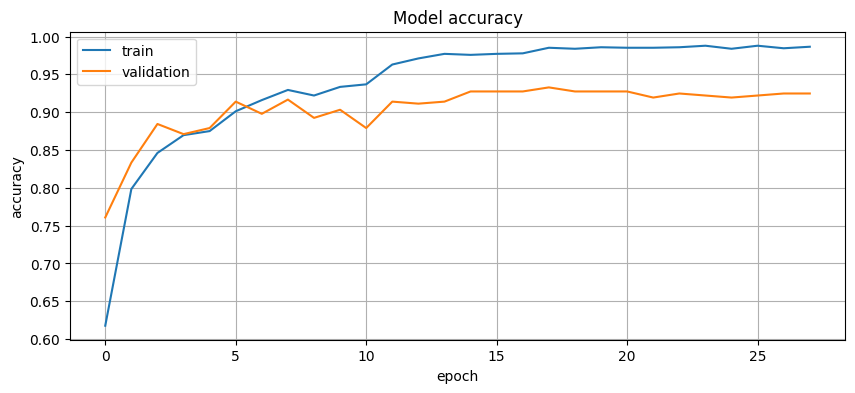

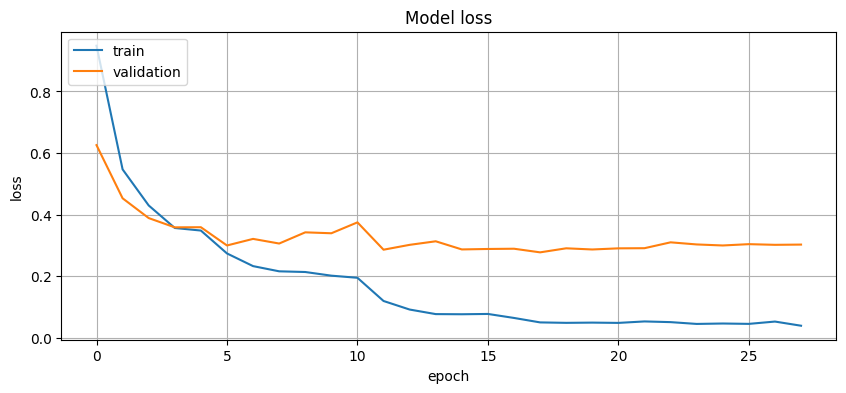

In [ ]:
# Membuat plot akurasi model VGG16
plt.figure(figsize=(10, 4))
plt.plot(history_vggv2.history['accuracy'])
plt.plot(history_vggv2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid(True)
plt.show()

# Membuat plot loss model VGG16
plt.figure(figsize=(10, 4))
plt.plot(history_vggv2.history['loss'])
plt.plot(history_vggv2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid(True)
plt.show()


In [ ]:
vggv2.save("v2.keras")

In [ ]:
vggv2.save("v2.h5")

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
my_model_3 = load_model("/content/v2.keras")

In [ ]:
my_model_3.evaluate(test_data)

1/1 [==============================] - 6s 6s/step - loss: 1.1054 - accuracy: 0.7200


[1.105446219444275, 0.7200000286102295]